6210407960 นายธนกร วงษ์สนิท

# train validate test split

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
cd ./Dataset/Dataset0_Original

/data/home/b6210407960/Dataset/Dataset0_Original


In [3]:
disease_types=['Normal', 'COVID']
path = '/data/home/b6210407960/Dataset/Dataset0_Original'
data_dir = os.path.join(path)

In [4]:
ls

CNN_Model_noAugment.hdf5          ResNet50_Model_Augment.hdf5
CNN_Model_noAugment_old.hdf5      ResNet50_Model_Augment_20epoch.hdf5
CNN_Model_noAugment_v2_3lay.hdf5  ResNet50_Model_noAugment.hdf5
CNN_Model_oversampling.hdf5       ResNet50_Model_noAugment_30epoch.hdf5
CNN_Model_undersampling.hdf5      ResNet50_Model_noAugment_dense1.hdf5
COVID/                            ResNet50_Model_oversampling_30epoch.hdf5
Normal/                           ResNet50_Model_undersampling_30epoch.hdf5
ResNet50_Model.hdf5


In [5]:
os.path.join(data_dir, disease_types[0])

'/data/home/b6210407960/Dataset/Dataset0_Original/Normal'

In [6]:
for defects_id, sp in enumerate(disease_types):
    print(defects_id, sp)

0 Normal
1 COVID


In [7]:
arr = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        arr.append(['{}/{}'.format(sp, file), defects_id, sp]) #defectID-> Normal=0,COVID=1  
df = pd.DataFrame(arr, columns=['File', 'DiseaseID','Disease Type'])

In [9]:
df.sample(5)

,File,DiseaseID,Disease Type
6269,Normal/Normal-1685.png,0,Normal
8285,Normal/Normal-4774.png,0,Normal
3072,Normal/Normal-6651.png,0,Normal
11136,COVID/COVID-2336.png,1,COVID
11379,COVID/COVID-2346.png,1,COVID


In [10]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(path, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)   

In [11]:
df['File'].values

array(['Normal/Normal-6196.png', 'Normal/Normal-7288.png',
       'Normal/Normal-1821.png', ..., 'COVID/COVID-789.png',
       'COVID/COVID-951.png', 'COVID/COVID-2465.png'], dtype=object)

## แบ่งชุดข้อมูล
- X_images คือ ชุดตัวแปรต้น
- Y_images คือ ชุดตัวแปรตามหรือผลเฉลย

In [13]:
dataset = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)) #arrayไว้เก็บ image ที่อ่าน
for i, file in tqdm(enumerate(df['File'].values)):
    image = read_image(file)
    if image is not None:
        dataset[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_images = dataset
print(X_images.shape)

13886it [01:45, 131.74it/s]

(13886, 64, 64, 3)


In [14]:
df['DiseaseID'].values

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
print('ratio -  {} '.format(np.bincount(df['DiseaseID'].values)))
print('ratio -  {} '.format(np.bincount(df['DiseaseID'].values)/len(df['DiseaseID'])))

ratio -  [10189  3697] 
ratio -  [0.73376062 0.26623938] 


In [17]:
Y_images = df['DiseaseID'].values
Y_images

array([0, 0, 0, ..., 1, 1, 1])

## แบ่งกลุ่มของข้อมูล

เพื่อที่จะทำการ train model, validate model และ test model ด้วยชุดข้อมูลที่ model ไม่เคยเห็นมาก่อน
* ข้อมูลชุด train model        `X_train`
* ชุดข้อมูลสำหรับ test model    `X_test`
* ชุดข้อมูลสำหรับ validate model`X_val`
* ชุดคำตอบของชุด train model  `Y_train`
* ชุดคำตอบของ validate model `Y_val`
* ชุดคำตอบของ test model     `Y_test`

In [18]:
X, X_test, Y, Y_test = train_test_split(X_images, Y_images, test_size=0.1, random_state = 42)

In [19]:
print('train -  {}               |   test -  {}'.format(np.bincount(Y), np.bincount(Y_test)))
print('train -  {}   |   test -  {}'.format(np.bincount(Y)/len(Y), np.bincount(Y_test)/len(Y_test)))

train -  [9162 3335]               |   test -  [1027  362]
train -  [0.73313595 0.26686405]   |   test -  [0.73938085 0.26061915]


In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [21]:
print('train -  {}             |   validate -  {}'.format(np.bincount(Y_train), np.bincount(Y_val)))
print('train -  {}   |   validate -  {}'.format(np.bincount(Y_train)/len(Y_train), np.bincount(Y_val)/len(Y_val)))

train -  [7287 2710]             |   validate -  [1875  625]
train -  [0.72891868 0.27108132]   |   validate -  [0.75 0.25]


In [22]:
#เช็คสัดส่วน ->สัดส่วนมีความไม่สมดุลกันระหว่างสองคลาส

In [23]:
Y_val[10:19]

array([0, 0, 0, 0, 0, 1, 0, 0, 0])

In [27]:
X_val[1][1][1]

array([15., 15., 15.])

###### สรุปสัดส่วน train val test

In [150]:
print('Dataset - ',len(Y_images))

Dataset -  13886


In [157]:
print('train -  {}                     | val -  {}          |   test -  {}'.format(len(Y_train), len(Y_val), len(Y_test)))
print('train -  {}                     | val -  {}          |   test -  {}'.format(round(len(Y_train)/len(Y_images),3), round(len(Y_val)/len(Y_images),3), round(len(Y_test)/len(Y_images),3)))
print('train -  {}              | val -  {}   |   test -  {}'.format(np.bincount(Y_train), np.bincount(Y_val), np.bincount(Y_test)))
print('train -  {}  | val -  {}   |   test -  {}'.format(np.bincount(Y_train)/len(Y_train), np.bincount(Y_val)/len(Y_val), np.bincount(Y_test)/len(Y_test)))

train -  9997                     | val -  2500          |   test -  1389
train -  0.72                     | val -  0.18          |   test -  0.1
train -  [7287 2710]              | val -  [1875  625]   |   test -  [1027  362]
train -  [0.72891868 0.27108132]  | val -  [0.75 0.25]   |   test -  [0.73938085 0.26061915]


## saveข้อมูลที่แบ่งลงfolder

In [28]:
pwd

'/data/home/b6210407960/Dataset/Dataset0_Original'

In [89]:
def save_image(iterator,y,numIm,where):
    countN = 0
    countC = 0
    for i in range(numIm):
        countNow = 0
        batch = iterator[i]
        image = batch.astype('uint8')
        if y[i]==0:
            #Normal case
            disease = 'Normal'
            countN = countN+1
            countNow = countN
        elif y[i]==1:
            #COVID case
            disease = 'COVID'
            countC = countC+1
            countNow = countC
        else:
            break
        path = '/data/home/b6210407960/Dataset/Dataset1_OriginalData/'+where+'/'+disease+'/'
        filename = path+where+disease+str(countNow)+'.png'
        cv2.imwrite(filename, image)

### test folder

In [90]:
1027+362

1389

In [91]:
save_image(X_test,Y_test,1389,'test')

In [92]:
ls '/data/home/b6210407960/Dataset/Dataset1_OriginalData/test'

COVID/  Normal/


In [93]:
len(os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/test/Normal'))

1027

In [94]:
os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/test/COVID')

['testCOVID1.png',
 'testCOVID2.png',
 'testCOVID3.png',
 'testCOVID4.png',
 'testCOVID5.png',
 'testCOVID6.png',
 'testCOVID7.png',
 'testCOVID8.png',
 'testCOVID9.png',
 'testCOVID10.png',
 'testCOVID11.png',
 'testCOVID12.png',
 'testCOVID13.png',
 'testCOVID14.png',
 'testCOVID15.png',
 'testCOVID16.png',
 'testCOVID17.png',
 'testCOVID18.png',
 'testCOVID19.png',
 'testCOVID20.png',
 'testCOVID21.png',
 'testCOVID22.png',
 'testCOVID23.png',
 'testCOVID24.png',
 'testCOVID25.png',
 'testCOVID26.png',
 'testCOVID27.png',
 'testCOVID28.png',
 'testCOVID29.png',
 'testCOVID30.png',
 'testCOVID31.png',
 'testCOVID32.png',
 'testCOVID33.png',
 'testCOVID34.png',
 'testCOVID35.png',
 'testCOVID36.png',
 'testCOVID37.png',
 'testCOVID38.png',
 'testCOVID39.png',
 'testCOVID40.png',
 'testCOVID41.png',
 'testCOVID42.png',
 'testCOVID43.png',
 'testCOVID44.png',
 'testCOVID45.png',
 'testCOVID46.png',
 'testCOVID47.png',
 'testCOVID48.png',
 'testCOVID49.png',
 'testCOVID50.png',
 'testCOV

In [95]:
len(os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/test/COVID'))

362

In [97]:
os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/test/Normal')

['testNormal1.png',
 'testNormal2.png',
 'testNormal3.png',
 'testNormal4.png',
 'testNormal5.png',
 'testNormal6.png',
 'testNormal7.png',
 'testNormal8.png',
 'testNormal9.png',
 'testNormal10.png',
 'testNormal11.png',
 'testNormal12.png',
 'testNormal13.png',
 'testNormal14.png',
 'testNormal15.png',
 'testNormal16.png',
 'testNormal17.png',
 'testNormal18.png',
 'testNormal19.png',
 'testNormal20.png',
 'testNormal21.png',
 'testNormal22.png',
 'testNormal23.png',
 'testNormal24.png',
 'testNormal25.png',
 'testNormal26.png',
 'testNormal27.png',
 'testNormal28.png',
 'testNormal29.png',
 'testNormal30.png',
 'testNormal31.png',
 'testNormal32.png',
 'testNormal33.png',
 'testNormal34.png',
 'testNormal35.png',
 'testNormal36.png',
 'testNormal37.png',
 'testNormal38.png',
 'testNormal39.png',
 'testNormal40.png',
 'testNormal41.png',
 'testNormal42.png',
 'testNormal43.png',
 'testNormal44.png',
 'testNormal45.png',
 'testNormal46.png',
 'testNormal47.png',
 'testNormal48.png',
 

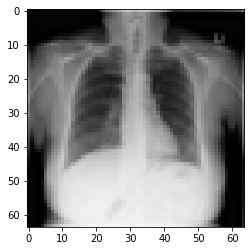

In [98]:
im1 = cv2.imread('/data/home/b6210407960/Dataset/Dataset1_OriginalData/test/Normal/testNormal12.png')
import matplotlib.pyplot as plt
plt.imshow(im1)

In [99]:
im1.shape

(64, 64, 3)

### val folder

In [100]:
1875+625

2500

In [101]:
save_image(X_val,Y_val,2500,'val')

In [103]:
len(os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/val/Normal'))

1875

In [104]:
len(os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/val/COVID'))

625

In [106]:
os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/val/Normal')

['valNormal1.png',
 'valNormal2.png',
 'valNormal3.png',
 'valNormal4.png',
 'valNormal5.png',
 'valNormal6.png',
 'valNormal7.png',
 'valNormal8.png',
 'valNormal9.png',
 'valNormal10.png',
 'valNormal11.png',
 'valNormal12.png',
 'valNormal13.png',
 'valNormal14.png',
 'valNormal15.png',
 'valNormal16.png',
 'valNormal17.png',
 'valNormal18.png',
 'valNormal19.png',
 'valNormal20.png',
 'valNormal21.png',
 'valNormal22.png',
 'valNormal23.png',
 'valNormal24.png',
 'valNormal25.png',
 'valNormal26.png',
 'valNormal27.png',
 'valNormal28.png',
 'valNormal29.png',
 'valNormal30.png',
 'valNormal31.png',
 'valNormal32.png',
 'valNormal33.png',
 'valNormal34.png',
 'valNormal35.png',
 'valNormal36.png',
 'valNormal37.png',
 'valNormal38.png',
 'valNormal39.png',
 'valNormal40.png',
 'valNormal41.png',
 'valNormal42.png',
 'valNormal43.png',
 'valNormal44.png',
 'valNormal45.png',
 'valNormal46.png',
 'valNormal47.png',
 'valNormal48.png',
 'valNormal49.png',
 'valNormal50.png',
 'valNorm

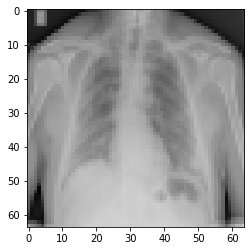

In [110]:
im1 = cv2.imread('/data/home/b6210407960/Dataset/Dataset1_OriginalData/val/COVID/valCOVID55.png')
import matplotlib.pyplot as plt
plt.imshow(im1)

In [111]:
im1.shape

(64, 64, 3)

In [120]:
7287-2710 #จำนวนที่ต้อง Augment เพิ่ม ถ้าต้องการแก้ไข Imbalanced data

4577

### train folder

In [112]:
7287+2710

9997

In [113]:
save_image(X_train,Y_train,9997,'train')

In [114]:
ls '/data/home/b6210407960/Dataset/Dataset1_OriginalData/train'

COVID/  Normal/


In [115]:
len(os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/train/Normal'))

7287

In [116]:
len(os.listdir('/data/home/b6210407960/Dataset/Dataset1_OriginalData/train/COVID'))

2710

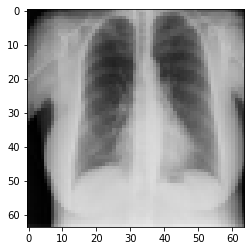

In [117]:
im1 = cv2.imread('/data/home/b6210407960/Dataset/Dataset1_OriginalData/train/COVID/trainCOVID123.png')
import matplotlib.pyplot as plt
plt.imshow(im1)

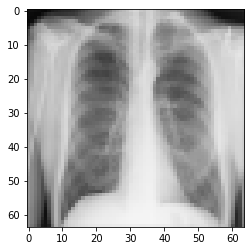

In [159]:
im2 = cv2.imread('/data/home/b6210407960/Dataset/Dataset1_OriginalData/train/Normal/trainNormal4798.png')
import matplotlib.pyplot as plt
plt.imshow(im2)

In [119]:
im1.shape

(64, 64, 3)

save folder ลงเครื่อง
`scp -P 22022 -r b6210407960@158.108.30.21:/data/home/b6210407960/Dataset/Dataset1_OriginalData .`

copy folder `cp -R /data/home/b6210407960/Dataset/Dataset1_OriginalData /data/home/b6210407960/Dataset/Dataset2_GeoTransformAndIntensity`

`cp -R /data/home/b6210407960/Dataset/Dataset1_OriginalData /data/home/b6210407960/Dataset/Dataset3_GenImage`